___
# Bone Abnormality Detection from X-Rays using Deep Learning
MSc in Data Science / NCSR Demokritos

Course: **Deep Learning**

Kastelianou Olympia, 2022202004006, dit2006dsc@office365.uop.gr 
___

## Check that GPU Runtime is selected

In [ ]:
!nvidia-smi

Mon Jun 28 07:04:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install missing packages

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 4.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=3e279c1320c7867260e5fb5c48e9db3a85410a6d7a00e7becdc3216d13dc99ce
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=70aa90a9ee4252ade4afd0aeb9974f79a13e0304ad1f3e92a2a607e6b0a0c1a1
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## Imports

In [ ]:
import gc
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sn
import tensorflow as tf
import time
%matplotlib inline

from PIL import Image

from kerastuner import HyperParameters, BayesianOptimization
from kerastuner.engine import trial as trial_module

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
import zipfile

log = logging.getLogger('tensorflow')
log.setLevel(logging.ERROR)

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


## Get the MURA-v1.1 dataset

In [ ]:
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

--2021-06-28 07:04:12--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  9.94MB/s    in 5m 15s  

2021-06-28 07:09:28 (10.2 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [ ]:
with zipfile.ZipFile('MURA-v1.1.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
DATASET_PATH = 'MURA-v1.1'

## Load the dataset

Here I created a helping function to load the dataset, since all information is in the filename column. I extract the type of the X-ray, the patientId, the study of each X-ray, then I calculate the column patient_study_type as the concat of the 3 above, since abnormality is classified per patient, study and type and finally I extract the abnormality and assign 0 to negative and 1 to positive class.

In [ ]:
def generate_df(csv_name):
    df = pd.read_csv(csv_name, header=None, names=['filename'])
    df['type'] = (df.filename.str.split('/')).str[2]
    df['patient'] = (df.filename.str.split('/')).str[3]
    df['study'] = (df.filename.str.extract('(study.*)_'))
    df['patient_study_type'] = df['patient'] + '_' + df['study'] + '_' + df['type']
    df['class'] = (df.filename.str.extract('study.*_(positive|negative)'))
    df['class'] = df['class'].replace('negative', 0)
    df['class'] = df['class'].replace('positive', 1)
    return df

The train dataset looks like:

In [ ]:
train_df_orig = generate_df(os.path.join(DATASET_PATH, 'train_image_paths.csv'))
train_df_orig

,filename,type,patient,study,patient_study_type,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1,patient00001_study1_XR_SHOULDER,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1,patient00001_study1_XR_SHOULDER,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1,patient00001_study1_XR_SHOULDER,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1,patient00002_study1_XR_SHOULDER,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1,patient00002_study1_XR_SHOULDER,1
...,...,...,...,...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,patient11183,study1,patient11183_study1_XR_HAND,0
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,patient11183,study1,patient11183_study1_XR_HAND,0
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,patient11184,study1,patient11184_study1_XR_HAND,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,patient11184,study1,patient11184_study1_XR_HAND,0


Here I make some quick statistics. We can see that for each type, of X-ray, how many X-rays we have, and how many of them belong to class 1.

In [ ]:
train_df_orig.groupby(['type']).agg({'filename': 'count', 'class': 'sum'})

,filename,class
type,,
XR_ELBOW,4931,2006
XR_FINGER,5106,1968
XR_FOREARM,1825,661
XR_HAND,5543,1484
XR_HUMERUS,1272,599
XR_SHOULDER,8379,4168
XR_WRIST,9752,3987


Then I split the train dataset into train and validation set, keeping 90% for training and 10% for validation, with respect to the type and class.

In [ ]:
train_df, val_df = train_test_split(train_df_orig, stratify=train_df_orig[['type', 'class']], test_size=0.1)

Here, we can see the final train, validation and test set that are going to be used.

In [ ]:
train_df.reset_index(inplace=True, drop=True)
train_df

,filename,type,patient,study,patient_study_type,class
0,MURA-v1.1/train/XR_ELBOW/patient05218/study1_p...,XR_ELBOW,patient05218,study1,patient05218_study1_XR_ELBOW,1
1,MURA-v1.1/train/XR_ELBOW/patient06091/study1_n...,XR_ELBOW,patient06091,study1,patient06091_study1_XR_ELBOW,0
2,MURA-v1.1/train/XR_SHOULDER/patient00478/study...,XR_SHOULDER,patient00478,study1,patient00478_study1_XR_SHOULDER,1
3,MURA-v1.1/train/XR_HUMERUS/patient03190/study1...,XR_HUMERUS,patient03190,study1,patient03190_study1_XR_HUMERUS,0
4,MURA-v1.1/train/XR_WRIST/patient07806/study1_n...,XR_WRIST,patient07806,study1,patient07806_study1_XR_WRIST,0
...,...,...,...,...,...,...
33122,MURA-v1.1/train/XR_WRIST/patient06904/study1_p...,XR_WRIST,patient06904,study1,patient06904_study1_XR_WRIST,1
33123,MURA-v1.1/train/XR_HAND/patient10847/study1_ne...,XR_HAND,patient10847,study1,patient10847_study1_XR_HAND,0
33124,MURA-v1.1/train/XR_WRIST/patient08099/study1_n...,XR_WRIST,patient08099,study1,patient08099_study1_XR_WRIST,0
33125,MURA-v1.1/train/XR_SHOULDER/patient02411/study...,XR_SHOULDER,patient02411,study1,patient02411_study1_XR_SHOULDER,0


In [ ]:
val_df.reset_index(inplace=True, drop=True)
val_df

,filename,type,patient,study,patient_study_type,class
0,MURA-v1.1/train/XR_HAND/patient10739/study1_ne...,XR_HAND,patient10739,study1,patient10739_study1_XR_HAND,0
1,MURA-v1.1/train/XR_SHOULDER/patient01868/study...,XR_SHOULDER,patient01868,study1,patient01868_study1_XR_SHOULDER,0
2,MURA-v1.1/train/XR_FOREARM/patient09643/study1...,XR_FOREARM,patient09643,study1,patient09643_study1_XR_FOREARM,0
3,MURA-v1.1/train/XR_ELBOW/patient05464/study1_n...,XR_ELBOW,patient05464,study1,patient05464_study1_XR_ELBOW,0
4,MURA-v1.1/train/XR_HAND/patient09977/study1_po...,XR_HAND,patient09977,study1,patient09977_study1_XR_HAND,1
...,...,...,...,...,...,...
3676,MURA-v1.1/train/XR_WRIST/patient06990/study1_p...,XR_WRIST,patient06990,study1,patient06990_study1_XR_WRIST,1
3677,MURA-v1.1/train/XR_FINGER/patient01179/study1_...,XR_FINGER,patient01179,study1,patient01179_study1_XR_FINGER,1
3678,MURA-v1.1/train/XR_HAND/patient04382/study1_ne...,XR_HAND,patient04382,study1,patient04382_study1_XR_HAND,0
3679,MURA-v1.1/train/XR_WRIST/patient08381/study1_n...,XR_WRIST,patient08381,study1,patient08381_study1_XR_WRIST,0


In [ ]:
test_df = generate_df(os.path.join(DATASET_PATH, 'valid_image_paths.csv'))
test_df

,filename,type,patient,study,patient_study_type,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1,patient11186_study1_XR_WRIST,1
...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0


## Plotting results
Here I  created 3 helping functions
1.   `display_samples`: A helping function to display the first few images of our train dataset, so that we get a feeling of our data
2.   `plot_history`: A helping function to plot the history of accuracy and loss of the networks trained
3.   `plot_confusion_matrix`: Taken from [Stack Overflow](https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels) in order to prettify the confusion matrix


In [ ]:
def display_samples(rows, cols):
    plt.figure(figsize=(25, 25))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = image.load_img(train_df_orig.iloc[i].filename)
        img_data = image.img_to_array(img) / 255.0
        plt.imshow(img_data, cmap=plt.cm.binary)

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Before I continue even further I plot some of the images so that I take a look of what they look like.

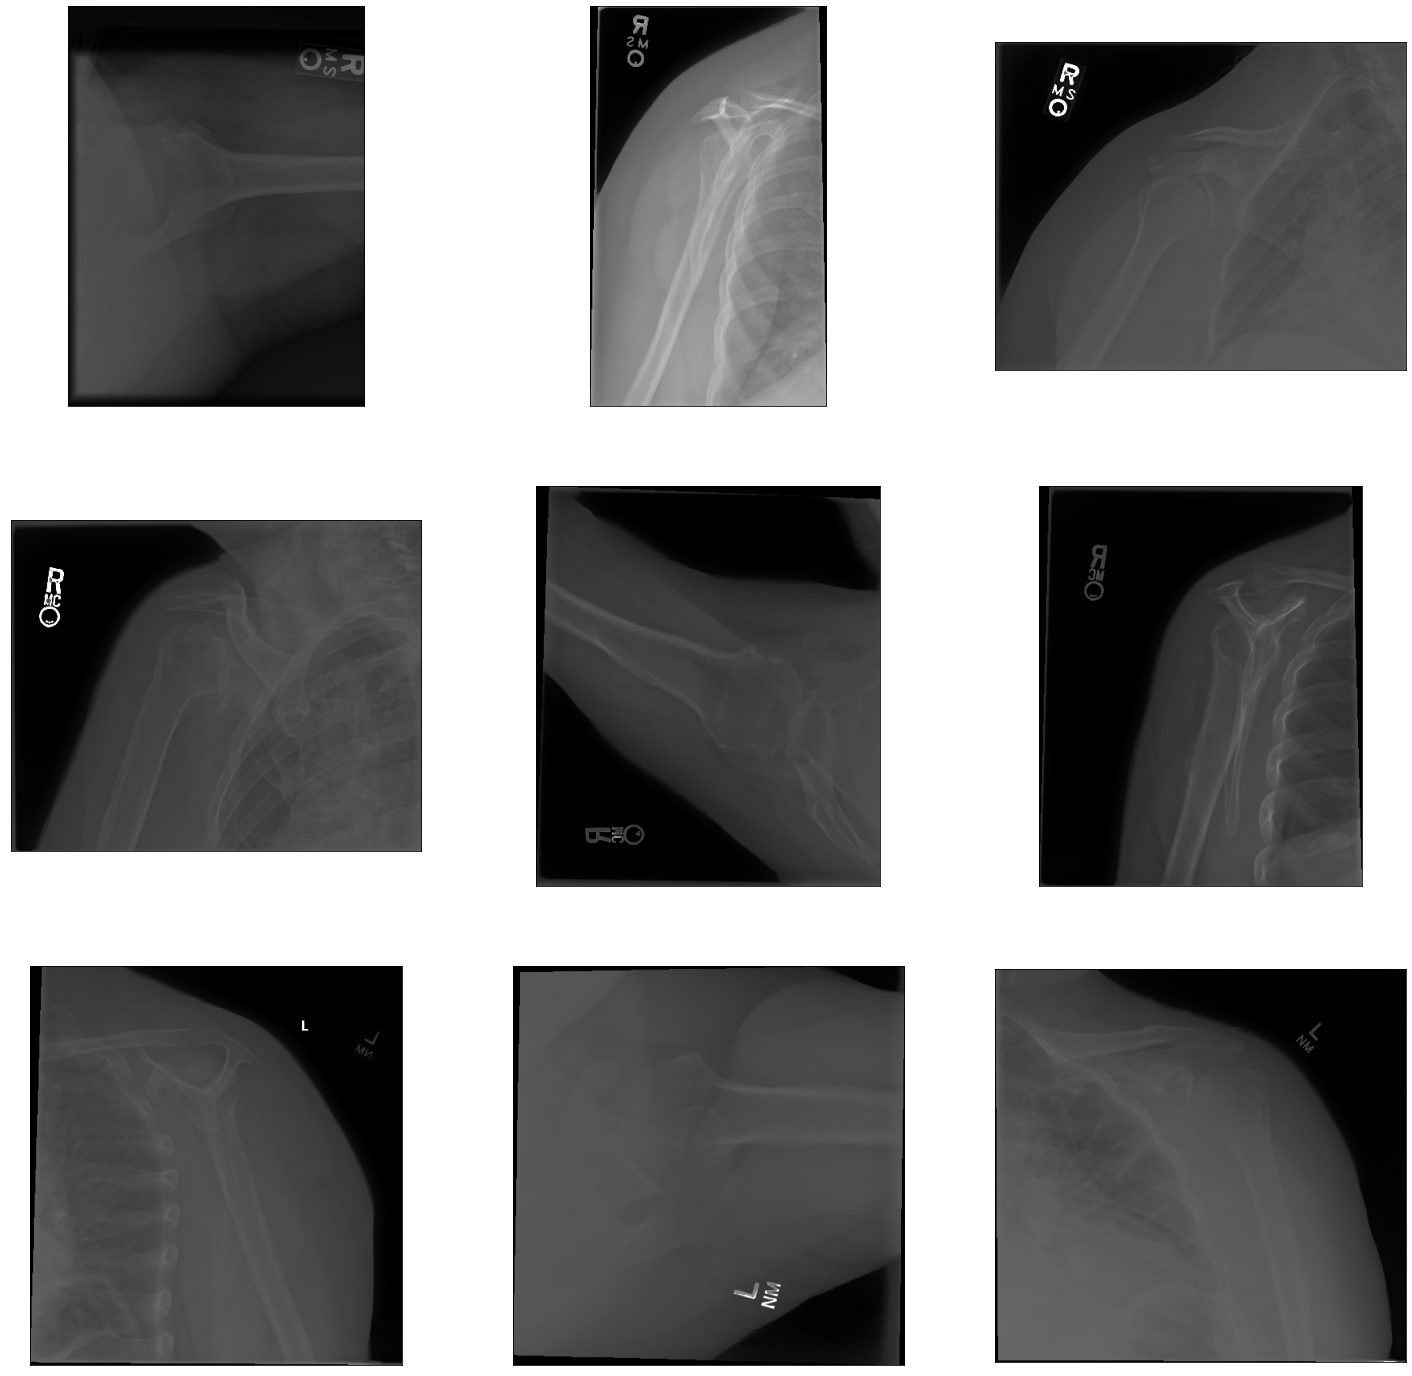

In [ ]:
display_samples(3, 3)

## Generation creation
In order to load the images at the neural network, I created image generators. These objects help us not overload the ram with the images and load only the ones that will be passed on the network. For the train dataset I created two generators. One that takes the images as they are in the dataset and one that flips a sample of the batch either horizontal or vertical, or rotates it by 5 degrees. Also, both of these generators don't take the images by the order they are on the dataset but they shuffle them.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255) # Generator for our data

Here I set the parameters for the models.


1.   `batch_size` I set it to the default value which is **32**
2.   `epochs_upper` The number of epochs that the upper part of the pretrained model will fit with the pretrained weights frozen
3.   `epochs` The number of epochs that the models will run
4.   `epochs_trial` The number of epochs that the models will run while searching for the best hyperparameters. Since the resources where limited, and the time per epoch was long, there was no time to search for the best hyperparameters. So, I just set this to **1** so as to show how it would be done. If I had more time for training, this would be equal to `epochs`
5.   `trials` The number of trials that the tuner will search for hyperparameters. Again if I had more time, this number would be set to **20**
6.   `IMG_HEIGHT` The height of the image
7.   `IMG_WIDTH` The width of the image



In [ ]:
batch_size = 32
epochs_upper = 8
epochs = 20
epochs_trial = 1
trials = 1
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_data_gen = datagen.flow_from_dataframe(train_df,
                                             x_col='filename',
                                             y_col='class',
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             color_mode='rgb',
                                             class_mode='raw',
                                             batch_size=batch_size,
                                             shuffle=True)

Found 33127 validated image filenames.


In [ ]:
train_data_gen_aug = datagen.flow_from_dataframe(train_df,
                                             rotation_range=5,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             x_col='filename',
                                             y_col='class',
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             color_mode='rgb',
                                             class_mode='raw',
                                             batch_size=batch_size,
                                             shuffle=True)

Found 33127 validated image filenames.


In [ ]:
val_data_gen = datagen.flow_from_dataframe(val_df,
                                           x_col='filename',
                                           y_col='class',
                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                           color_mode='rgb',
                                           class_mode='raw',
                                           batch_size=batch_size,
                                           shuffle=False)

Found 3681 validated image filenames.


In [ ]:
test_data_gen = datagen.flow_from_dataframe(test_df,
                                            x_col='filename',
                                            y_col='class',
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',
                                            class_mode='raw',
                                            batch_size=batch_size,
                                            shuffle=False)

Found 3197 validated image filenames.


## Models Creation, Tuning & Training

Here I override the ReturnBestEarlyStopping so as to return the weights from the best epoch

In [ ]:
class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

For the CNN model I created the `build_cnn_model` that creates and returns the model based on the hyperparameters I pass. 

Also, since the problem is to classify an image between two classes, the output layer is now a Dense of one unit, and the activation function being a sigmoid, so as to get the probabily of the possitive class 

In [ ]:
def build_cnn_model(hp):
    
    # Define the input layer.
    inputs = Input(
        shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        name='Input'
    )

    x = inputs
    # Define the convolutional layers.
    for i in range(hp['conv_layers']):
        x = Conv2D(
            filters=32*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation='relu',
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if hp['dropout_rate'] > 0:
          x = Dropout(
              rate=hp['dropout_rate'],
              name='Dropout-{0:d}'.format(i + 1)
          )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    outputs = Dense(
        units=1,
        activation='sigmoid',
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary() # Print a description of the model.
    return model

Since I have one number of trials, I give the tuner only one possible value for the convolutional layers and one possible value for the dropout rate. 

Given more time, it would be worth to search the dropout rate in range of [0, 0.5] and the layers from 2 to 5. After the trials are complete I return the best hyperparameters

In [ ]:
tunable_parameters = {
    'conv_layers': [4],
    'dropout_rate': [0.3]
    }

hp = HyperParameters()
for parameter_name, parameter_value in tunable_parameters.items():
    hp.Choice(parameter_name, parameter_value)

tuner = BayesianOptimization(
        hypermodel=build_cnn_model,
        hyperparameters=hp,
        objective='val_accuracy',
        max_trials=trials,
        overwrite=True
        )

early_stopping = ReturnBestEarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
    )

tuner.search_space_summary()
tuner.search(
    train_data_gen,
    validation_data=val_data_gen,
    verbose=1,
    epochs=epochs_trial,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
    )

print('Tuning results')
tuner.results_summary()
best_params_cnn = tuner.get_best_hyperparameters(num_trials=1)[0].values
best_model_cnn = tuner.get_best_models(num_models=1)[0]

Trial 1 Complete [00h 03m 11s]
val_accuracy: 0.596576988697052

Best val_accuracy So Far: 0.596576988697052
Total elapsed time: 00h 03m 11s
Tuning results
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_layers: 4
dropout_rate: 0.3
Score: 0.596576988697052
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 112, 112, 32)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 112, 112, 32)      0         
______________________________

Having found the best hyperparameters, now I create a CNN model with those hyperparameters and train it.

In [ ]:
best_cnn_model = build_cnn_model(best_params_cnn)

cnn_hs = best_cnn_model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    verbose=1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 112, 112, 32)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 56, 56, 64)        0   

Then, I train a second CNN with the same hyperparameters, with the only difference being that I give the augmented generator as the train data.

In [ ]:
best_cnn_model_aug = build_cnn_model(best_params_cnn)

cnn_hs_aug = best_cnn_model_aug.fit(
    train_data_gen_aug,
    validation_data=val_data_gen,
    verbose=1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 112, 112, 32)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 56, 56, 64)        0   

Having created and fitted the CNN models, it is time to create a pretrained model. The model of my choise was the ResNet50 but I skip the upper layer so as to modify it to answer for our problem. Also, the type of pooling to be used will be max and the pretrained weights will be the ones of the imagenet dataset. 

Then I create an MLP layer on top of the ResNet model so as to predict the class of our problem having as inputs, the output of the ResNet model. 

For the purposes of the hyperparameter tuning, I created to types of build functions that are essentially the same. The differences are:

*   `build_resnet_model_hp(hp)`: Freezes the weights of the pretrained model so as the hyperparameter tuning is done only for the MLP layer and returns the whole model 
*   `build_resnet_model(hp)`: Just creates the model and returns the pretrained model and the full model



In [ ]:
def build_resnet_model_hp(hp):

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        pooling='max',
    )

    x = base_model.output
    # Define the remaining hidden layers.
    for i in range(hp['hidden_layers']):
        x = Dense(
            units=hp['hidden_units'],
            kernel_initializer='glorot_uniform',
            activation='relu',
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if hp['dropout_rate'] > 0:
          x = Dropout(rate=hp['dropout_rate'])(x)
        
    # Define the output layer.
    output = Dense(
        units=1,
        activation='sigmoid',
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=base_model.input, outputs=output)
    
    # First train the upper layers for a few epochs
    for layer in base_model.layers:
      layer.trainable = False

    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    model.summary() # Print a description of the model.

    return model

In [ ]:
def build_resnet_model(hp):

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='max',
    )

    x = base_model.output
    # Define the remaining hidden layers.
    for i in range(hp['hidden_layers']):
        x = Dense(
            units=hp['hidden_units'],
            kernel_initializer='glorot_uniform',
            activation='relu',
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if hp['dropout_rate'] > 0:
          x = Dropout(rate=hp['dropout_rate'])(x)
        
    # Define the output layer.
    output = Dense(
        units=1,
        activation='sigmoid',
        name='Output'
    )(x)

    # Define the model.
    model = Model(inputs=base_model.input, outputs=output)
    
    return base_model, model

Same as before, since I search for hyperparameters for one trial, the tunable parameters of my choice have only one possible value. If I could run it for more trials then search space for each one would be:


*   hidden_layers [2, 3, 4, 5]
*   hidden_units [256, 512, 1024]
*   dropout_rate [0.0, 0.1, 0.2, 0.3, 0.4]



In [ ]:
tunable_parameters = {
    'hidden_layers': [3],
    'hidden_units': [512],
    'dropout_rate': [0.3]
    }

hp = HyperParameters()
for parameter_name, parameter_value in tunable_parameters.items():
    hp.Choice(parameter_name, parameter_value)

tuner = BayesianOptimization(
        hypermodel=build_resnet_model_hp,
        hyperparameters=hp,
        objective='val_accuracy',
        max_trials=trials,
        overwrite=True
        )

early_stopping = ReturnBestEarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
    )

tuner.search_space_summary()
tuner.search(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs_trial,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
    )

print('Tuning results')
tuner.results_summary()
best_params_resnet = tuner.get_best_hyperparameters(num_trials=1)[0].values
best_model_resnet = tuner.get_best_models(num_models=1)[0]

Trial 1 Complete [00h 02m 56s]
val_accuracy: 0.5957620143890381

Best val_accuracy So Far: 0.5957620143890381
Total elapsed time: 00h 02m 56s
Tuning results
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
hidden_layers: 3
hidden_units: 512
dropout_rate: 0.3
Score: 0.5957620143890381
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_c

Having fould the best hyperparameters, I now create a new model with those, and train it. The fitting is performed as follows. 

First I fit only the upper MLP layer for a few epochs(8) and I keep the rest of the model frozen. For that purpose I keep the learning rate relatively high(0.001). After that, I unfreeze the weights of the model and I reduce the learning rate to 0.00001 so as to not forget the pretrained weights and just update them accordingly so as to focus on our problem.  

In [ ]:
early_stopping = ReturnBestEarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
    )

base_model_resnet, best_full_model_resnet = build_resnet_model(best_params_resnet)

# First train the upper layers for a few epochs
for layer in base_model_resnet.layers:
    layer.trainable = False

best_full_model_resnet.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

#model_resnet.summary() # Print a description of the model.

hs_upper_layers = best_full_model_resnet.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs_upper,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print('Finished training upper layers.')
print('------------------')

# Now train the whole network with a low learning rate
for layer in base_model_resnet.layers:
    layer.trainable = True

best_full_model_resnet.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
              
best_full_model_resnet.summary() # Print a description of the model.

hs_best_full_model_resnet = best_full_model_resnet.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
              
print('Finished training full network.')
print('------------------')

Epoch 1/8
1036/1036 [==============================] - 170s 162ms/step - loss: 0.7311 - accuracy: 0.5731 - val_loss: 0.6636 - val_accuracy: 0.5958
Epoch 2/8
1036/1036 [==============================] - 167s 161ms/step - loss: 0.6705 - accuracy: 0.5915 - val_loss: 0.6608 - val_accuracy: 0.5958
Epoch 3/8
1036/1036 [==============================] - 166s 160ms/step - loss: 0.6680 - accuracy: 0.6000 - val_loss: 0.6612 - val_accuracy: 0.5958

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/8
1036/1036 [==============================] - 165s 160ms/step - loss: 0.6675 - accuracy: 0.5937 - val_loss: 0.6617 - val_accuracy: 0.5958
Epoch 5/8
1036/1036 [==============================] - 164s 159ms/step - loss: 0.6649 - accuracy: 0.5945 - val_loss: 0.6612 - val_accuracy: 0.5974
Epoch 6/8
1036/1036 [==============================] - 164s 158ms/step - loss: 0.6637 - accuracy: 0.5963 - val_loss: 0.6588 - val_accuracy: 0.6017
Epoch 7/8
1036/1036 [===============

Same as before, I create a second model with the ResNet as the basemodel, with the only difference that now it takes as input the augmented data generator.

In [ ]:
early_stopping = ReturnBestEarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
    )

base_model_resnet_aug, best_full_model_resnet_aug = build_resnet_model(best_params_resnet)

# First train the upper layers for a few epochs
for layer in base_model_resnet_aug.layers:
    layer.trainable = False

best_full_model_resnet_aug.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

best_full_model_resnet_aug.summary() # Print a description of the model.

hs_upper_layers_aug = best_full_model_resnet_aug.fit(
    train_data_gen_aug,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs_upper,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print('Finished training upper layers.')
print('------------------')

# Now train the whole network with a low learning rate
for layer in base_model_resnet_aug.layers:
    layer.trainable = True

best_full_model_resnet_aug.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
              
best_full_model_resnet_aug.summary() # Print a description of the model.

hs_best_full_model_resnet_aug = best_full_model_resnet_aug.fit(
    train_data_gen_aug,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
              
print('Finished training full network.')
print('------------------')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Models Evaluation
Having trained all the models, now is the time to evaluate them. In order to do that I get the predictions for both validation and test set for each model and I store them in a new validation and test dataframe along with the actual classes.

In [ ]:
val_predictions_cnn = best_cnn_model.predict(val_data_gen)
test_predictions_cnn = best_cnn_model.predict(test_data_gen)

In [ ]:
val_predictions_cnn_aug = best_cnn_model_aug.predict(val_data_gen)
test_predictions_cnn_aug = best_cnn_model_aug.predict(test_data_gen)

In [ ]:
val_predictions_resnet = best_full_model_resnet.predict(val_data_gen)
test_predictions_resnet = best_full_model_resnet.predict(test_data_gen)

In [ ]:
val_predictions_resnet_aug = best_full_model_resnet_aug.predict(val_data_gen)
test_predictions_resnet_aug = best_full_model_resnet_aug.predict(test_data_gen)

In [ ]:
val_df_prob = pd.concat([val_df, pd.DataFrame(val_predictions_cnn, columns=['prob_cnn'])], axis=1)
val_df_prob['pred_cnn'] = np.where(val_df_prob['prob_cnn'] > 0.5, 1, 0)
val_df_prob = pd.concat([val_df_prob, pd.DataFrame(val_predictions_cnn_aug, columns=['prob_cnn_aug'])], axis=1)
val_df_prob['pred_cnn_aug'] = np.where(val_df_prob['prob_cnn_aug'] > 0.5, 1, 0)
val_df_prob = pd.concat([val_df_prob, pd.DataFrame(val_predictions_resnet, columns=['prob_resnet'])], axis=1)
val_df_prob['pred_resnet'] = np.where(val_df_prob['prob_resnet'] > 0.5, 1, 0)
val_df_prob = pd.concat([val_df_prob, pd.DataFrame(val_predictions_resnet_aug, columns=['prob_resnet_aug'])], axis=1)
val_df_prob['pred_resnet_aug'] = np.where(val_df_prob['prob_resnet_aug'] > 0.5, 1, 0)
val_df_prob

,filename,type,patient,study,patient_study_type,class,prob_cnn,pred_cnn,prob_cnn_aug,pred_cnn_aug,prob_resnet,pred_resnet,prob_resnet_aug,pred_resnet_aug
0,MURA-v1.1/train/XR_HAND/patient10739/study1_ne...,XR_HAND,patient10739,study1,patient10739_study1_XR_HAND,0,0.243538,0,0.354234,0,0.043705,0,0.000584,0
1,MURA-v1.1/train/XR_SHOULDER/patient01868/study...,XR_SHOULDER,patient01868,study1,patient01868_study1_XR_SHOULDER,0,0.357580,0,0.495274,0,0.150896,0,0.014070,0
2,MURA-v1.1/train/XR_FOREARM/patient09643/study1...,XR_FOREARM,patient09643,study1,patient09643_study1_XR_FOREARM,0,0.509902,1,0.701866,1,0.178114,0,0.218990,0
3,MURA-v1.1/train/XR_ELBOW/patient05464/study1_n...,XR_ELBOW,patient05464,study1,patient05464_study1_XR_ELBOW,0,0.347524,0,0.313117,0,0.519892,1,0.124644,0
4,MURA-v1.1/train/XR_HAND/patient09977/study1_po...,XR_HAND,patient09977,study1,patient09977_study1_XR_HAND,1,0.594405,1,0.602632,1,0.999735,1,0.999944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,MURA-v1.1/train/XR_WRIST/patient06990/study1_p...,XR_WRIST,patient06990,study1,patient06990_study1_XR_WRIST,1,0.876962,1,0.955645,1,0.999827,1,0.999670,1
3677,MURA-v1.1/train/XR_FINGER/patient01179/study1_...,XR_FINGER,patient01179,study1,patient01179_study1_XR_FINGER,1,0.451321,0,0.501469,1,0.961158,1,0.098361,0
3678,MURA-v1.1/train/XR_HAND/patient04382/study1_ne...,XR_HAND,patient04382,study1,patient04382_study1_XR_HAND,0,0.314160,0,0.444040,0,0.131744,0,0.000620,0
3679,MURA-v1.1/train/XR_WRIST/patient08381/study1_n...,XR_WRIST,patient08381,study1,patient08381_study1_XR_WRIST,0,0.202028,0,0.318561,0,0.044131,0,0.000221,0


In [ ]:
test_df_prob = pd.concat([test_df, pd.DataFrame(test_predictions_cnn, columns=['prob_cnn'])], axis=1)
test_df_prob['pred_cnn'] = np.where(test_df_prob['prob_cnn'] > 0.5, 1, 0)
test_df_prob = pd.concat([test_df_prob, pd.DataFrame(test_predictions_cnn_aug, columns=['prob_cnn_aug'])], axis=1)
test_df_prob['pred_cnn_aug'] = np.where(test_df_prob['prob_cnn_aug'] > 0.5, 1, 0)
test_df_prob = pd.concat([test_df_prob, pd.DataFrame(test_predictions_resnet, columns=['prob_resnet'])], axis=1)
test_df_prob['pred_resnet'] = np.where(test_df_prob['prob_resnet'] > 0.5, 1, 0)
test_df_prob = pd.concat([test_df_prob, pd.DataFrame(test_predictions_resnet_aug, columns=['prob_resnet_aug'])], axis=1)
test_df_prob['pred_resnet_aug'] = np.where(test_df_prob['prob_resnet_aug'] > 0.5, 1, 0)
test_df_prob

,filename,type,patient,study,patient_study_type,class,prob_cnn,pred_cnn,prob_cnn_aug,pred_cnn_aug,prob_resnet,pred_resnet,prob_resnet_aug,pred_resnet_aug
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.519771,1,0.437362,0,0.983592,1,0.999597,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.566723,1,0.430443,0,0.971659,1,0.954966,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.286811,0,0.302799,0,0.989718,1,0.577548,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.394132,0,0.386046,0,0.968232,1,0.994092,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1,patient11186_study1_XR_WRIST,1,0.396886,0,0.312849,0,0.995816,1,0.991743,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.022017,0,0.057114,0,0.000647,0,0.000284,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.056033,0,0.167556,0,0.040626,0,0.001194,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.037706,0,0.115286,0,0.000659,0,0.000004,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.091436,0,0.360589,0,0.011364,0,0.000004,0


Since the actual class is the same for each patient_study_type I aggregated the probabilities of each model to that level by taking the average and the max, and then I made the predictions based on that aggregations.

In [ ]:
val_df_prob_avg = val_df_prob.groupby(['patient_study_type'], as_index=False).agg(
    {'class': 'mean', 'prob_cnn': 'mean', 'prob_cnn_aug': 'mean', 'prob_resnet': 'mean', 'prob_resnet_aug': 'mean'}
)
val_df_prob_avg['pred_cnn_avg'] = np.where(val_df_prob_avg['prob_cnn'] > 0.5, 1, 0)
val_df_prob_avg['pred_cnn_avg_aug'] = np.where(val_df_prob_avg['prob_cnn_aug'] > 0.5, 1, 0)
val_df_prob_avg['pred_resnet_avg'] = np.where(val_df_prob_avg['prob_resnet'] > 0.5, 1, 0)
val_df_prob_avg['pred_resnet_avg_aug'] = np.where(val_df_prob_avg['prob_resnet_aug'] > 0.5, 1, 0)
val_df_prob_avg.rename({'prob_cnn' : 'prob_cnn_avg', 'prob_cnn_aug' : 'prob_cnn_avg_aug', 'prob_resnet' : 'prob_resnet_avg', 'prob_resnet_aug' : 'prob_resnet_avg_aug'}, axis=1, inplace=True)
val_df_prob_avg

,patient_study_type,class,prob_cnn_avg,prob_cnn_avg_aug,prob_resnet_avg,prob_resnet_avg_aug,pred_cnn_avg,pred_cnn_avg_aug,pred_resnet_avg,pred_resnet_avg_aug
0,patient00003_study1_XR_SHOULDER,1,0.406218,0.343457,0.931420,0.907868,0,0,1,1
1,patient00012_study1_XR_SHOULDER,1,0.565328,0.647326,0.999090,0.999970,1,1,1,1
2,patient00012_study1_XR_WRIST,0,0.402175,0.401822,0.939700,0.495200,0,0,1,0
3,patient00016_study1_XR_SHOULDER,1,0.373827,0.399873,0.216859,0.009290,0,0,0,0
4,patient00017_study1_XR_SHOULDER,1,0.480109,0.475931,0.437480,0.984898,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3340,patient11164_study1_XR_HAND,0,0.146952,0.211280,0.016704,0.003029,0,0,0,0
3341,patient11169_study1_XR_HAND,0,0.173142,0.211287,0.023684,0.000022,0,0,0,0
3342,patient11170_study1_XR_HAND,0,0.410596,0.342630,0.010336,0.006388,0,0,0,0
3343,patient11182_study1_XR_HAND,0,0.107637,0.211625,0.003662,0.005290,0,0,0,0


In [ ]:
test_df_prob_avg = test_df_prob.groupby(['patient_study_type'], as_index=False).agg(
    {'class': 'mean', 'prob_cnn': 'mean', 'prob_cnn_aug': 'mean', 'prob_resnet': 'mean', 'prob_resnet_aug': 'mean'}
)
test_df_prob_avg['pred_cnn_avg'] = np.where(test_df_prob_avg['prob_cnn'] > 0.5, 1, 0)
test_df_prob_avg['pred_cnn_avg_aug'] = np.where(test_df_prob_avg['prob_cnn_aug'] > 0.5, 1, 0)
test_df_prob_avg['pred_resnet_avg'] = np.where(test_df_prob_avg['prob_resnet'] > 0.5, 1, 0)
test_df_prob_avg['pred_resnet_avg_aug'] = np.where(test_df_prob_avg['prob_resnet_aug'] > 0.5, 1, 0)
test_df_prob_avg.rename({'prob_cnn' : 'prob_cnn_avg', 'prob_cnn_aug' : 'prob_cnn_avg_aug', 'prob_resnet' : 'prob_resnet_avg', 'prob_resnet_aug' : 'prob_resnet_avg_aug'}, axis=1, inplace=True)
test_df_prob_avg

,patient_study_type,class,prob_cnn_avg,prob_cnn_avg_aug,prob_resnet_avg,prob_resnet_avg_aug,pred_cnn_avg,pred_cnn_avg_aug,pred_resnet_avg,pred_resnet_avg_aug
0,patient11185_study1_XR_WRIST,1,0.441859,0.389162,0.978300,8.815510e-01,0,0,1,1
1,patient11186_study1_XR_ELBOW,1,0.470228,0.486505,0.981127,9.952866e-01,0,0,1,1
2,patient11186_study1_XR_HUMERUS,1,0.411191,0.451883,0.991423,9.998808e-01,0,0,1,1
3,patient11186_study1_XR_SHOULDER,1,0.480292,0.490778,0.950757,7.651991e-01,0,0,1,1
4,patient11186_study1_XR_WRIST,1,0.348688,0.372437,0.989217,9.936747e-01,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1194,patient11963_study1_XR_FINGER,0,0.348410,0.319982,0.519522,4.423876e-01,0,0,1,0
1195,patient11964_study1_XR_FINGER,0,0.092167,0.139362,0.014294,1.669577e-04,0,0,0,0
1196,patient11965_study1_XR_FINGER,0,0.045145,0.265623,0.005848,1.713294e-07,0,0,0,0
1197,patient11966_study1_XR_FINGER,0,0.173756,0.104423,0.001393,1.571058e-02,0,0,0,0


In [ ]:
val_df_prob_max = val_df_prob.groupby(['patient_study_type'], as_index=False).agg(
    {'class': 'max', 'prob_cnn': 'max', 'prob_cnn_aug': 'max', 'prob_resnet': 'max', 'prob_resnet_aug': 'max'}
)
val_df_prob_max['pred_cnn_max'] = np.where(val_df_prob_max['prob_cnn'] > 0.5, 1, 0)
val_df_prob_max['pred_cnn_max_aug'] = np.where(val_df_prob_max['prob_cnn_aug'] > 0.5, 1, 0)
val_df_prob_max['pred_resnet_max'] = np.where(val_df_prob_max['prob_resnet'] > 0.5, 1, 0)
val_df_prob_max['pred_resnet_max_aug'] = np.where(val_df_prob_max['prob_resnet_aug'] > 0.5, 1, 0)
val_df_prob_max.rename({'prob_cnn' : 'prob_cnn_max', 'prob_cnn_aug' : 'prob_cnn_max_aug', 'prob_resnet' : 'prob_resnet_max', 'prob_resnet_aug' : 'prob_resnet_max_aug'}, axis=1, inplace=True)
val_df_prob_max

,patient_study_type,class,prob_cnn_max,prob_cnn_max_aug,prob_resnet_max,prob_resnet_max_aug,pred_cnn_max,pred_cnn_max_aug,pred_resnet_max,pred_resnet_max_aug
0,patient00003_study1_XR_SHOULDER,1,0.406218,0.343457,0.931420,0.907868,0,0,1,1
1,patient00012_study1_XR_SHOULDER,1,0.565328,0.647326,0.999090,0.999970,1,1,1,1
2,patient00012_study1_XR_WRIST,0,0.540015,0.438140,0.971541,0.942946,1,0,1,1
3,patient00016_study1_XR_SHOULDER,1,0.373827,0.399873,0.216859,0.009290,0,0,0,0
4,patient00017_study1_XR_SHOULDER,1,0.589324,0.480846,0.839161,0.999897,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
3340,patient11164_study1_XR_HAND,0,0.146952,0.211280,0.016704,0.003029,0,0,0,0
3341,patient11169_study1_XR_HAND,0,0.173142,0.211287,0.023684,0.000022,0,0,0,0
3342,patient11170_study1_XR_HAND,0,0.410596,0.342630,0.010336,0.006388,0,0,0,0
3343,patient11182_study1_XR_HAND,0,0.107637,0.211625,0.003662,0.005290,0,0,0,0


In [ ]:
test_df_prob_max = test_df_prob.groupby(['patient_study_type'], as_index=False).agg(
    {'class': 'max', 'prob_cnn': 'max', 'prob_cnn_aug': 'max', 'prob_resnet': 'max', 'prob_resnet_aug': 'max'}
)
test_df_prob_max['pred_cnn_max'] = np.where(test_df_prob_max['prob_cnn'] > 0.5, 1, 0)
test_df_prob_max['pred_cnn_max_aug'] = np.where(test_df_prob_max['prob_cnn_aug'] > 0.5, 1, 0)
test_df_prob_max['pred_resnet_max'] = np.where(test_df_prob_max['prob_resnet'] > 0.5, 1, 0)
test_df_prob_max['pred_resnet_max_aug'] = np.where(test_df_prob_max['prob_resnet_aug'] > 0.5, 1, 0)
test_df_prob_max.rename({'prob_cnn' : 'prob_cnn_max', 'prob_cnn_aug' : 'prob_cnn_max_aug', 'prob_resnet' : 'prob_resnet_max', 'prob_resnet_aug' : 'prob_resnet_max_aug'}, axis=1, inplace=True)
test_df_prob_max

,patient_study_type,class,prob_cnn_max,prob_cnn_max_aug,prob_resnet_max,prob_resnet_max_aug,pred_cnn_max,pred_cnn_max_aug,pred_resnet_max,pred_resnet_max_aug
0,patient11185_study1_XR_WRIST,1,0.566723,0.437362,0.989718,9.995973e-01,1,0,1,1
1,patient11186_study1_XR_ELBOW,1,0.555706,0.532736,0.999733,9.999989e-01,1,1,1,1
2,patient11186_study1_XR_HUMERUS,1,0.487067,0.633613,0.996516,9.999561e-01,0,1,1,1
3,patient11186_study1_XR_SHOULDER,1,0.525698,0.558356,0.997470,9.989759e-01,1,1,1,1
4,patient11186_study1_XR_WRIST,1,0.396886,0.432025,0.995816,9.956064e-01,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1194,patient11963_study1_XR_FINGER,0,0.415704,0.361854,0.996279,8.817192e-01,0,0,1,1
1195,patient11964_study1_XR_FINGER,0,0.150819,0.255516,0.026448,3.068431e-04,0,0,0,0
1196,patient11965_study1_XR_FINGER,0,0.045145,0.265623,0.005848,1.713294e-07,0,0,0,0
1197,patient11966_study1_XR_FINGER,0,0.279842,0.179467,0.002958,4.665629e-02,0,0,0,0


Then I joined the aggregations with the pictures so as to take the predictions to all the X-rays and compare the results

In [ ]:
val_df_prob = pd.merge(pd.merge(val_df_prob, val_df_prob_avg, on=["patient_study_type", "class"]), val_df_prob_max, on=["patient_study_type", "class"])
test_df_prob = pd.merge(pd.merge(test_df_prob, test_df_prob_avg, on=["patient_study_type", "class"]), test_df_prob_max, on=["patient_study_type", "class"])

In [ ]:
val_df_prob

,filename,type,patient,study,patient_study_type,class,prob_cnn,pred_cnn,prob_cnn_aug,pred_cnn_aug,prob_resnet,pred_resnet,prob_resnet_aug,pred_resnet_aug,prob_cnn_avg,prob_cnn_avg_aug,prob_resnet_avg,prob_resnet_avg_aug,pred_cnn_avg,pred_cnn_avg_aug,pred_resnet_avg,pred_resnet_avg_aug,prob_cnn_max,prob_cnn_max_aug,prob_resnet_max,prob_resnet_max_aug,pred_cnn_max,pred_cnn_max_aug,pred_resnet_max,pred_resnet_max_aug
0,MURA-v1.1/train/XR_HAND/patient10739/study1_ne...,XR_HAND,patient10739,study1,patient10739_study1_XR_HAND,0,0.243538,0,0.354234,0,0.043705,0,0.000584,0,0.243538,0.354234,0.043705,0.000584,0,0,0,0,0.243538,0.354234,0.043705,0.000584,0,0,0,0
1,MURA-v1.1/train/XR_SHOULDER/patient01868/study...,XR_SHOULDER,patient01868,study1,patient01868_study1_XR_SHOULDER,0,0.357580,0,0.495274,0,0.150896,0,0.014070,0,0.357580,0.495274,0.150896,0.014070,0,0,0,0,0.357580,0.495274,0.150896,0.014070,0,0,0,0
2,MURA-v1.1/train/XR_FOREARM/patient09643/study1...,XR_FOREARM,patient09643,study1,patient09643_study1_XR_FOREARM,0,0.509902,1,0.701866,1,0.178114,0,0.218990,0,0.509902,0.701866,0.178114,0.218990,1,1,0,0,0.509902,0.701866,0.178114,0.218990,1,1,0,0
3,MURA-v1.1/train/XR_ELBOW/patient05464/study1_n...,XR_ELBOW,patient05464,study1,patient05464_study1_XR_ELBOW,0,0.347524,0,0.313117,0,0.519892,1,0.124644,0,0.347524,0.313117,0.519892,0.124644,0,0,1,0,0.347524,0.313117,0.519892,0.124644,0,0,1,0
4,MURA-v1.1/train/XR_HAND/patient09977/study1_po...,XR_HAND,patient09977,study1,patient09977_study1_XR_HAND,1,0.594405,1,0.602632,1,0.999735,1,0.999944,1,0.594405,0.602632,0.999735,0.999944,1,1,1,1,0.594405,0.602632,0.999735,0.999944,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,MURA-v1.1/train/XR_WRIST/patient06990/study1_p...,XR_WRIST,patient06990,study1,patient06990_study1_XR_WRIST,1,0.876962,1,0.955645,1,0.999827,1,0.999670,1,0.876962,0.955645,0.999827,0.999670,1,1,1,1,0.876962,0.955645,0.999827,0.999670,1,1,1,1
3677,MURA-v1.1/train/XR_FINGER/patient01179/study1_...,XR_FINGER,patient01179,study1,patient01179_study1_XR_FINGER,1,0.451321,0,0.501469,1,0.961158,1,0.098361,0,0.451321,0.501469,0.961158,0.098361,0,1,1,0,0.451321,0.501469,0.961158,0.098361,0,1,1,0
3678,MURA-v1.1/train/XR_HAND/patient04382/study1_ne...,XR_HAND,patient04382,study1,patient04382_study1_XR_HAND,0,0.314160,0,0.444040,0,0.131744,0,0.000620,0,0.314160,0.444040,0.131744,0.000620,0,0,0,0,0.314160,0.444040,0.131744,0.000620,0,0,0,0
3679,MURA-v1.1/train/XR_WRIST/patient08381/study1_n...,XR_WRIST,patient08381,study1,patient08381_study1_XR_WRIST,0,0.202028,0,0.318561,0,0.044131,0,0.000221,0,0.202028,0.318561,0.044131,0.000221,0,0,0,0,0.202028,0.318561,0.044131,0.000221,0,0,0,0


In [ ]:
test_df_prob

,filename,type,patient,study,patient_study_type,class,prob_cnn,pred_cnn,prob_cnn_aug,pred_cnn_aug,prob_resnet,pred_resnet,prob_resnet_aug,pred_resnet_aug,prob_cnn_avg,prob_cnn_avg_aug,prob_resnet_avg,prob_resnet_avg_aug,pred_cnn_avg,pred_cnn_avg_aug,pred_resnet_avg,pred_resnet_avg_aug,prob_cnn_max,prob_cnn_max_aug,prob_resnet_max,prob_resnet_max_aug,pred_cnn_max,pred_cnn_max_aug,pred_resnet_max,pred_resnet_max_aug
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.519771,1,0.437362,0,0.983592,1,0.999597,1,0.441859,0.389162,0.978300,0.881551,0,0,1,1,0.566723,0.437362,0.989718,0.999597,1,0,1,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.566723,1,0.430443,0,0.971659,1,0.954966,1,0.441859,0.389162,0.978300,0.881551,0,0,1,1,0.566723,0.437362,0.989718,0.999597,1,0,1,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.286811,0,0.302799,0,0.989718,1,0.577548,1,0.441859,0.389162,0.978300,0.881551,0,0,1,1,0.566723,0.437362,0.989718,0.999597,1,0,1,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.394132,0,0.386046,0,0.968232,1,0.994092,1,0.441859,0.389162,0.978300,0.881551,0,0,1,1,0.566723,0.437362,0.989718,0.999597,1,0,1,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1,patient11186_study1_XR_WRIST,1,0.396886,0,0.312849,0,0.995816,1,0.991743,1,0.348688,0.372437,0.989217,0.993675,0,0,1,1,0.396886,0.432025,0.995816,0.995606,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.022017,0,0.057114,0,0.000647,0,0.000284,0,0.030399,0.075788,0.023913,0.000690,0,0,0,0,0.056033,0.167556,0.040626,0.001194,0,0,0,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.056033,0,0.167556,0,0.040626,0,0.001194,0,0.030399,0.075788,0.023913,0.000690,0,0,0,0,0.056033,0.167556,0.040626,0.001194,0,0,0,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.037706,0,0.115286,0,0.000659,0,0.000004,0,0.061494,0.220809,0.005152,0.000076,0,0,0,0,0.091436,0.360589,0.011364,0.000220,0,0,0,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.091436,0,0.360589,0,0.011364,0,0.000004,0,0.061494,0.220809,0.005152,0.000076,0,0,0,0,0.091436,0.360589,0.011364,0.000220,0,0,0,0


### Classification Reports
Here I print all the classification reports. The classification report is different based on:

1.   aug: If we used the augmented generator or not
2.   opt: If we report the validation results or the test results
3.   model: If it was the CNN or the ResNet model
4.   method: If the original probabilities derived from the model are evaluated, the average aggregation or the max aggregation 



In [ ]:
target_names = ['Negative', 'Positive']
for aug in ['non-Augmented', 'Augmented']:
  for opt in ['Val', 'Test']:

      for model in ['CNN', 'ResNet']:

        for method in ['Original', 'AVG', 'MAX']:
          print('\n', opt, ' Classification Report', model, aug, method, '\n', '-'*30, '\n',)
          if (aug=='non-Augmented'):
            if (opt=='Val'):
              if (model=='CNN'):
                if (method == 'Original'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_max'], 
                      target_names=target_names,
                      digits=3
                      ))
              else:
                if (method == 'Original'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_avg'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_max'], 
                      target_names=target_names,
                      digits=3
                      ))
            else:
              if (model=='CNN'):
                if (method == 'Original'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_cnn_max'], 
                      target_names=target_names,
                      digits=3
                      ))
              else:
                if (method == 'Original'):
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_avg'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_max'], 
                      target_names=target_names,
                      digits=3
                      ))
          else:
            if (opt=='Val'):
              if (model=='CNN'):
                if (method == 'Original'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_max_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
              else:
                if (method == 'Original'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_avg_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_max_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
            else:
              if (model=='CNN'):
                if (method == 'Original'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_cnn_max_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
              else:
                if (method == 'Original'):
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                elif (method == 'AVG'):
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_avg_aug'], 
                      target_names=target_names,
                      digits=3
                      ))
                else:
                  print(classification_report(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_max_aug'], 
                      target_names=target_names,
                      digits=3
                      ))


 Val  Classification Report CNN non-Augmented Original 
 ------------------------------ 

              precision    recall  f1-score   support

    Negative      0.681     0.883     0.769      2193
    Positive      0.693     0.390     0.499      1488

    accuracy                          0.684      3681
   macro avg      0.687     0.636     0.634      3681
weighted avg      0.686     0.684     0.660      3681


 Val  Classification Report CNN non-Augmented AVG 
 ------------------------------ 

              precision    recall  f1-score   support

    Negative      0.684     0.893     0.775      2193
    Positive      0.714     0.392     0.507      1488

    accuracy                          0.691      3681
   macro avg      0.699     0.643     0.641      3681
weighted avg      0.696     0.691     0.666      3681


 Val  Classification Report CNN non-Augmented MAX 
 ------------------------------ 

              precision    recall  f1-score   support

    Negative      0.687     

### Confusion Matrixes
Here we print all the confusion matrixes. The confusion matrix is different based on the same level as the classification report



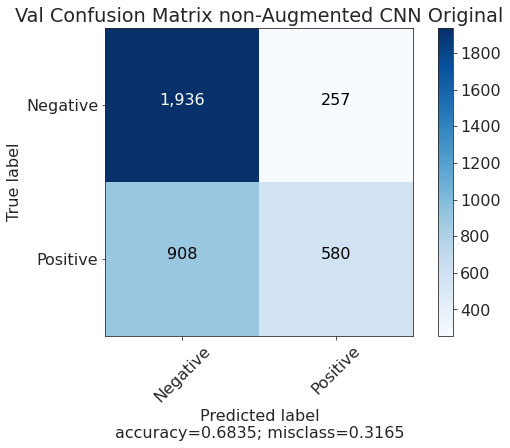

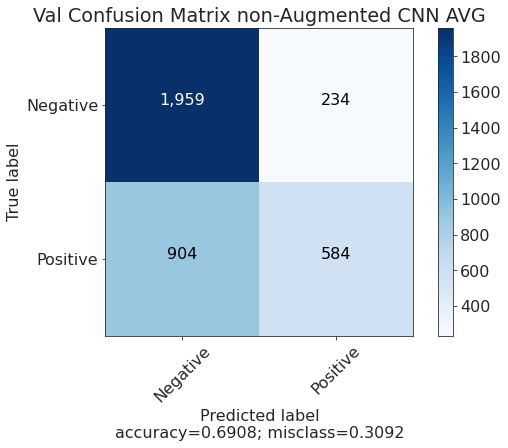

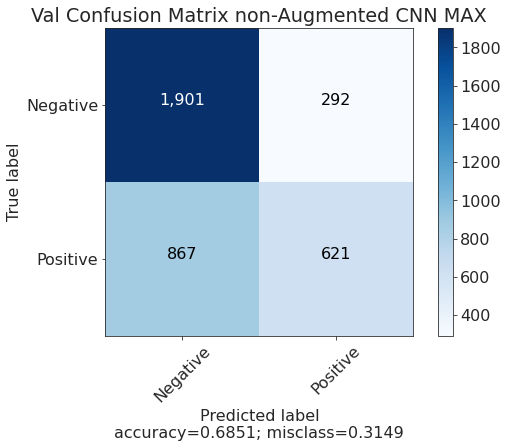

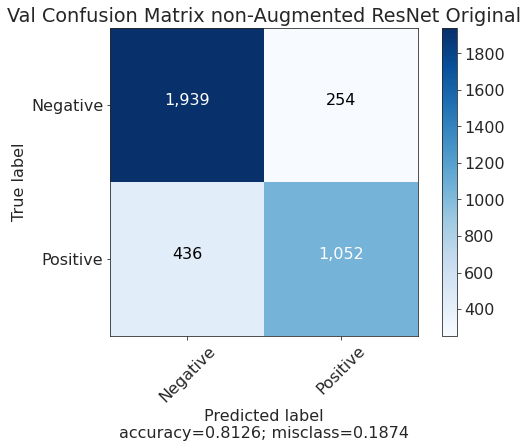

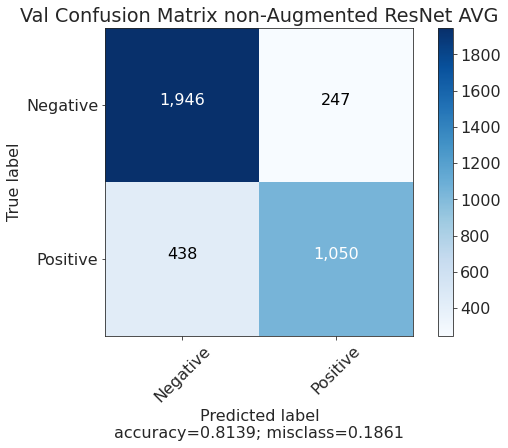

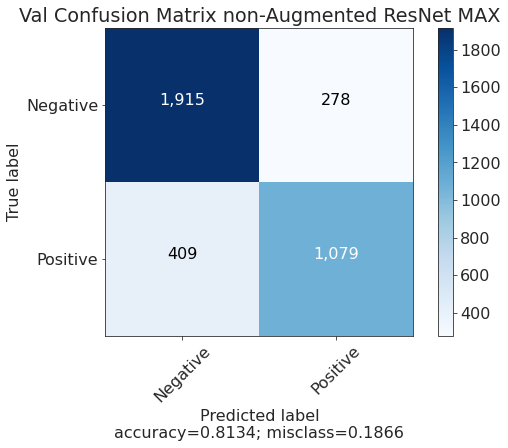

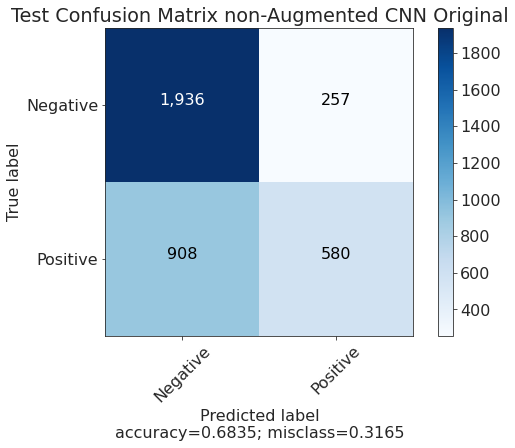

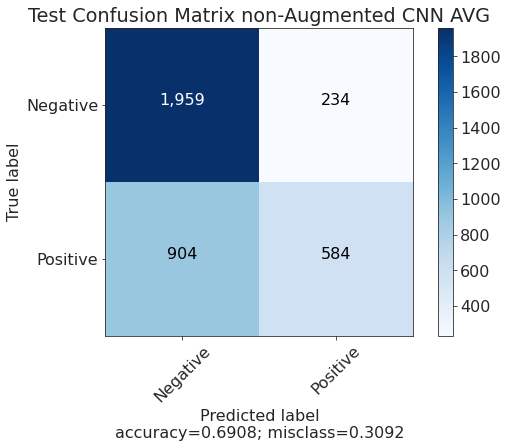

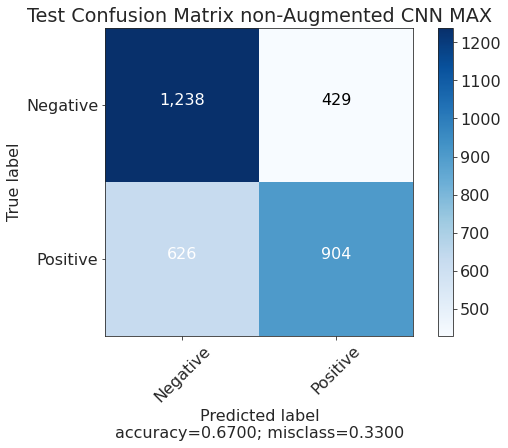

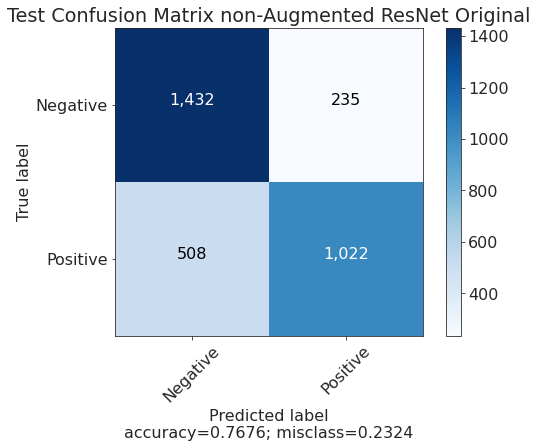

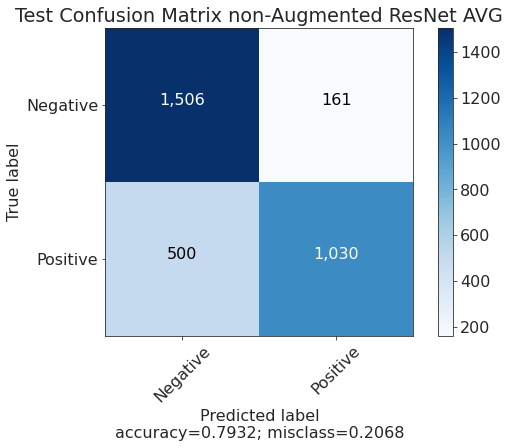

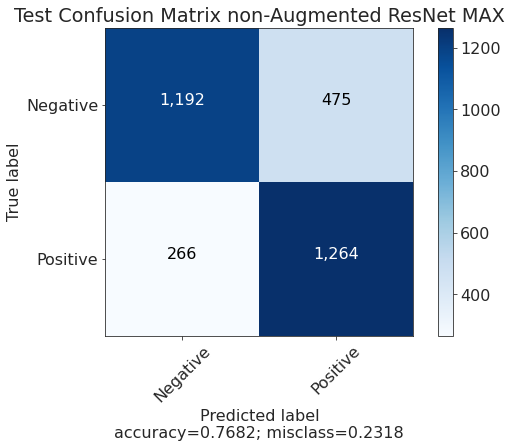

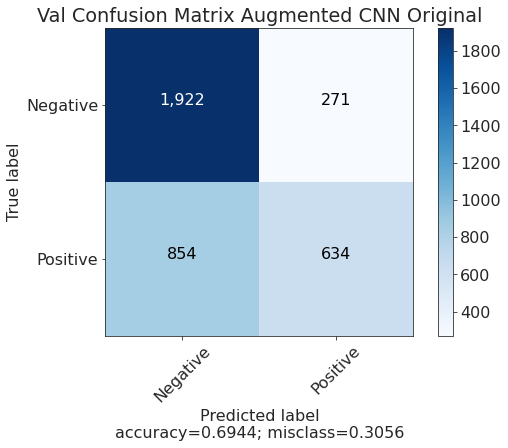

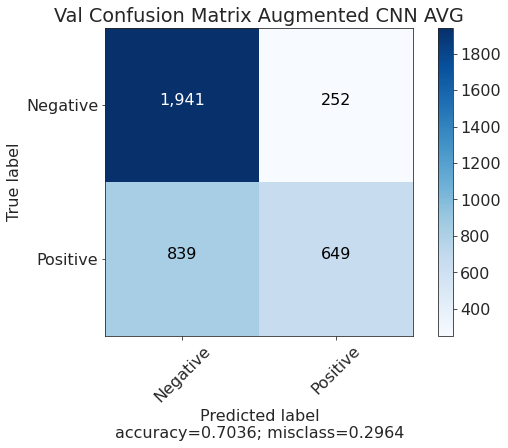

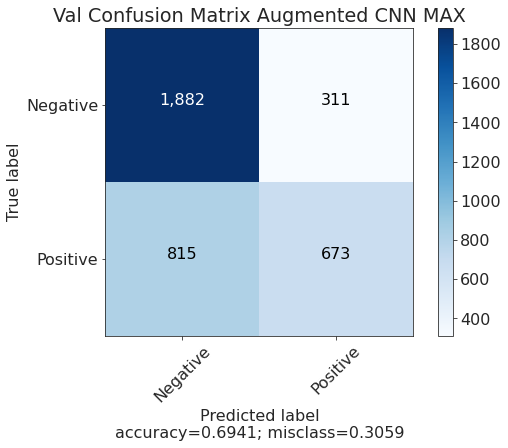

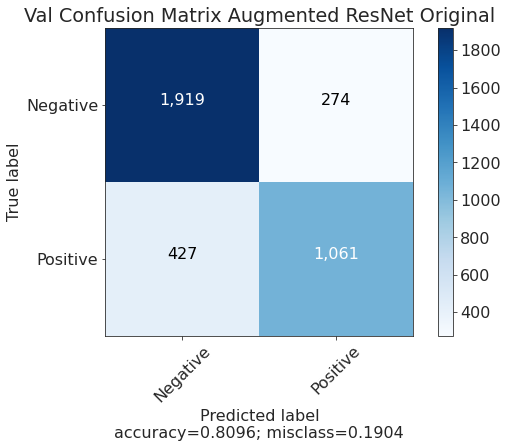

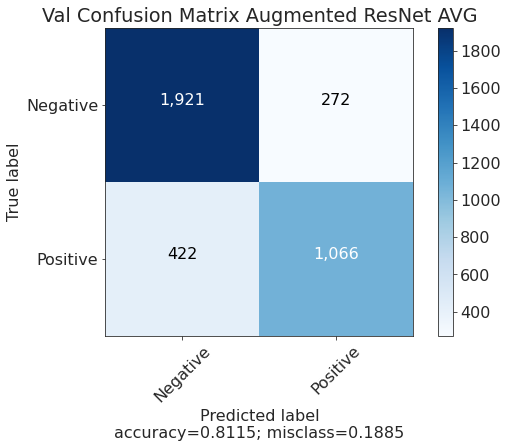

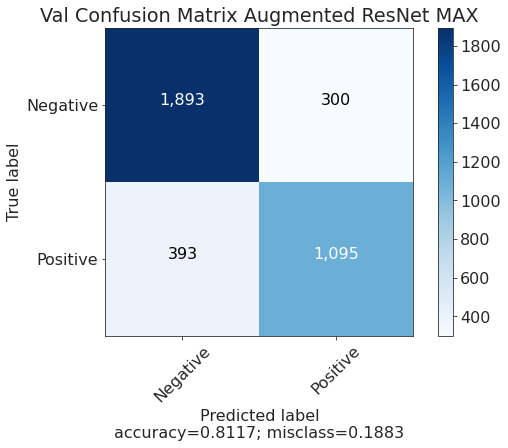

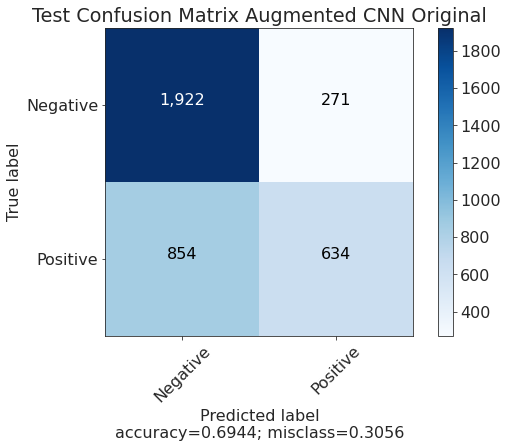

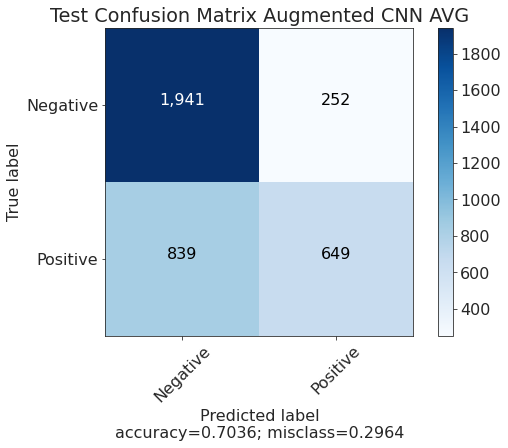

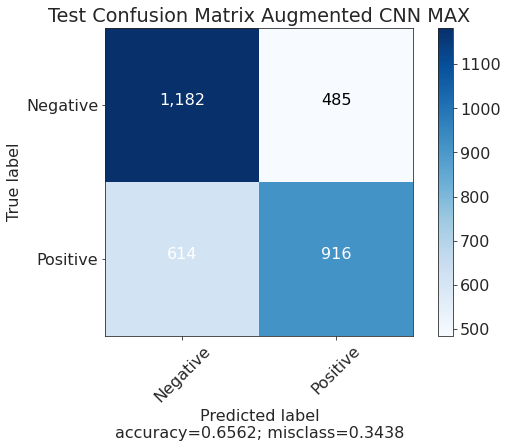

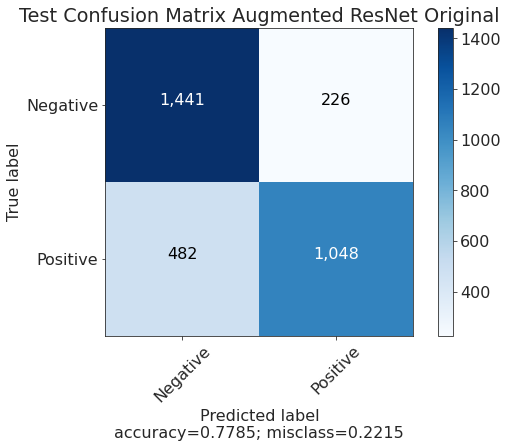

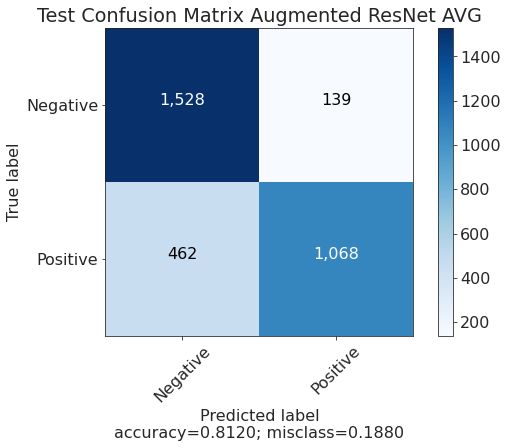

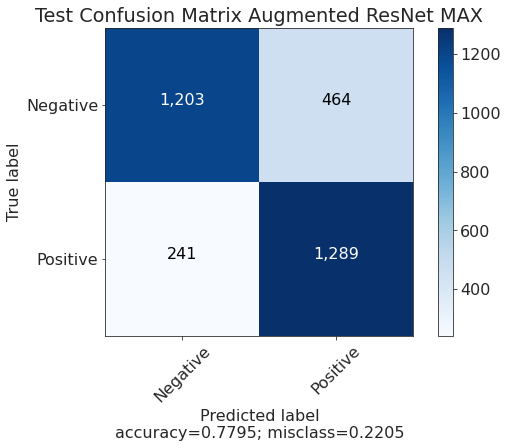

In [ ]:
sn.set_style('ticks')
target_names = ['Negative', 'Positive']
for aug in ['non-Augmented', 'Augmented']:
  for opt in ['Val', 'Test']:

      for model in ['CNN', 'ResNet']:

        for method in ['Original', 'AVG', 'MAX']:
          title = opt + ' Confusion Matrix ' + aug + ' ' + model + ' ' + method
          if (aug == 'non-Augmented'):
            if (opt=='Val'):
              if (model=='CNN'):
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_max'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
              else:
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_avg'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_max'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
            else:
              if (model=='CNN'):
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_cnn_max'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
              else:
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_avg'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_max'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
          else:
            if (opt=='Val'):
              if (model=='CNN'):
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_max_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
              else:
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_avg_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_resnet_max_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
            else:
              if (model=='CNN'):
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=val_df_prob['class'], 
                      y_pred=val_df_prob['pred_cnn_avg_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_cnn_max_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
              else:
                if (method == 'Original'):
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                elif (method == 'AVG'):
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_avg_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)
                else:
                  cm = confusion_matrix(
                      y_true=test_df_prob['class'], 
                      y_pred=test_df_prob['pred_resnet_max_aug'])
                  plot_confusion_matrix(cm, target_names= target_names, title = title, normalize=False)            

Based on the validation set results, we see that the augmentation didn't achieved better accuracy and the best model would be the "ResNet non-Augmented AVG".

But if we take into consideration the test accuracy as well, we  can see that the augmentation achieved a better generalization thus ResNet Augmented AVG  would be the best model.

### Loss and Accuracy per model per set

#### CNN model

In [ ]:
# Evaluate on test data and show all the results.
best_cnn_model_eval = best_cnn_model.evaluate(test_data_gen, verbose=1)

100/100 [==============================] - 12s 123ms/step - loss: 0.6404 - accuracy: 0.6372


Train Loss     : 0.53214
Validation Loss: 0.57869
Test Loss      : 0.64037
---
Train Accuracy     : 0.72533
Validation Accuracy: 0.68351
Test Accuracy      : 0.63716



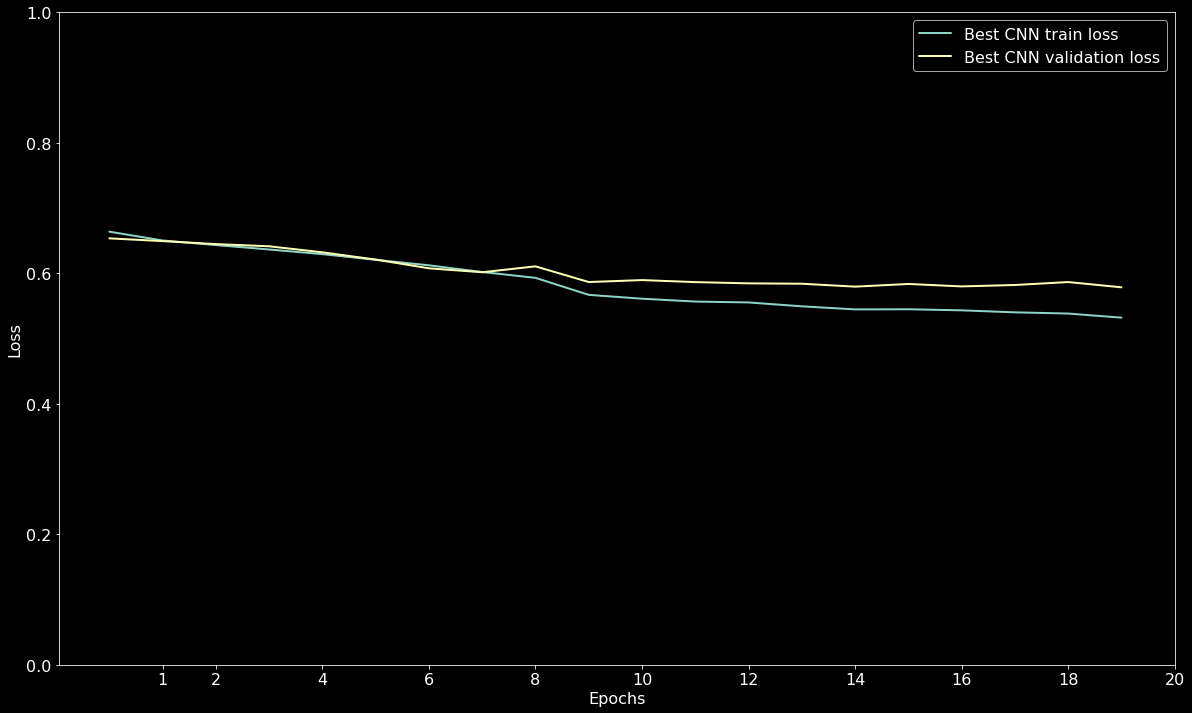

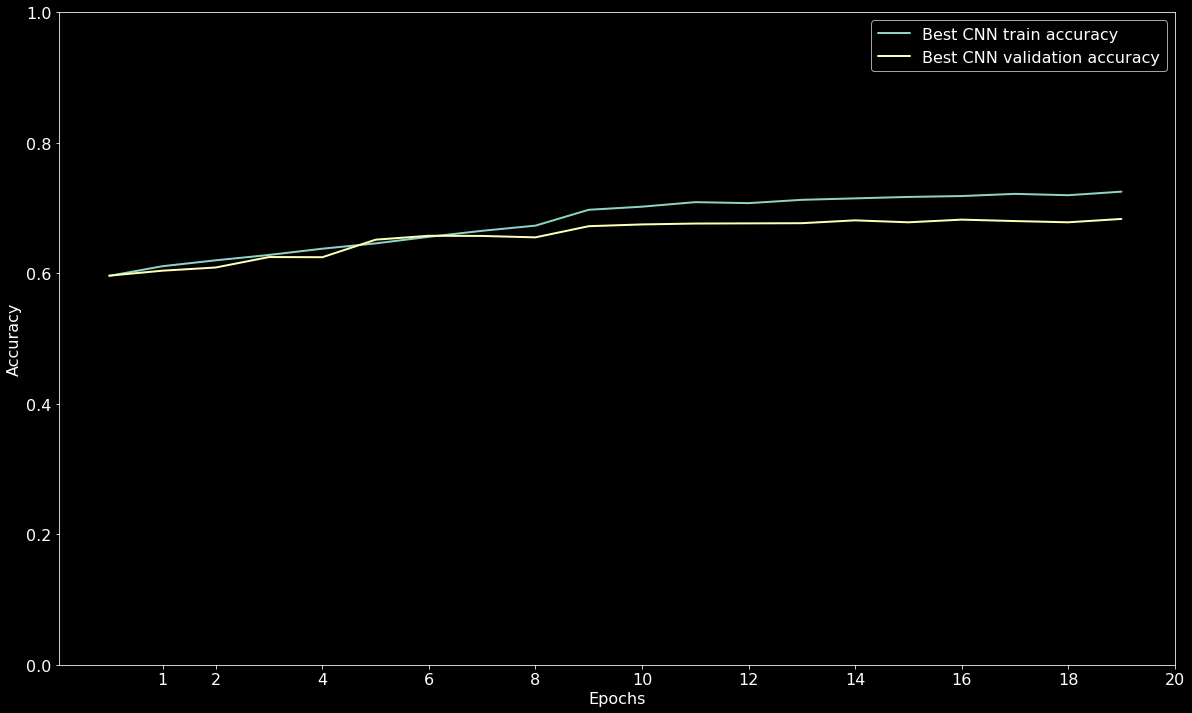

In [ ]:
print("Train Loss     : {0:.5f}".format(cnn_hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(cnn_hs.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(best_cnn_model_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(cnn_hs.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(cnn_hs.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(best_cnn_model_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'Best CNN': cnn_hs}, epochs=epochs, metric='loss')
plot_history(hs={'Best CNN': cnn_hs}, epochs=epochs, metric='accuracy')

In [ ]:
# Evaluate on test data and show all the results.
best_cnn_model_aug_eval = best_cnn_model_aug.evaluate(test_data_gen, verbose=1)

100/100 [==============================] - 12s 124ms/step - loss: 0.6424 - accuracy: 0.6337


Train Loss     : 0.51865
Validation Loss: 0.57888
Test Loss      : 0.64243
---
Train Accuracy     : 0.73876
Validation Accuracy: 0.69356
Test Accuracy      : 0.63372



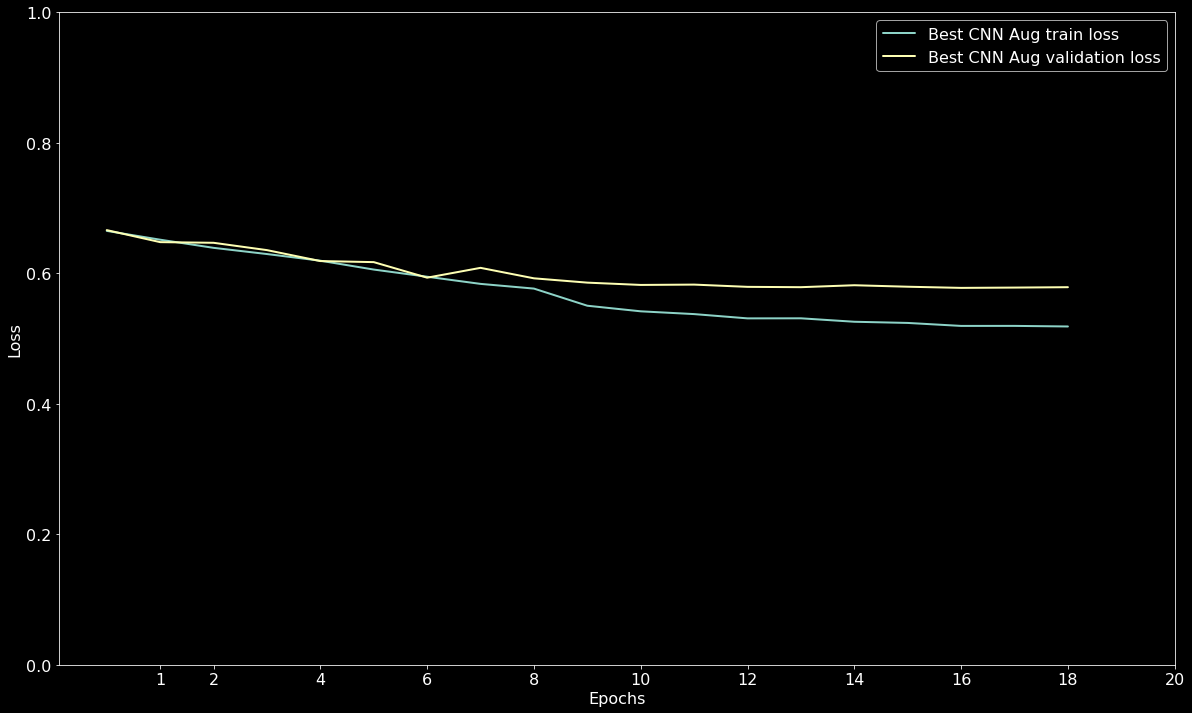

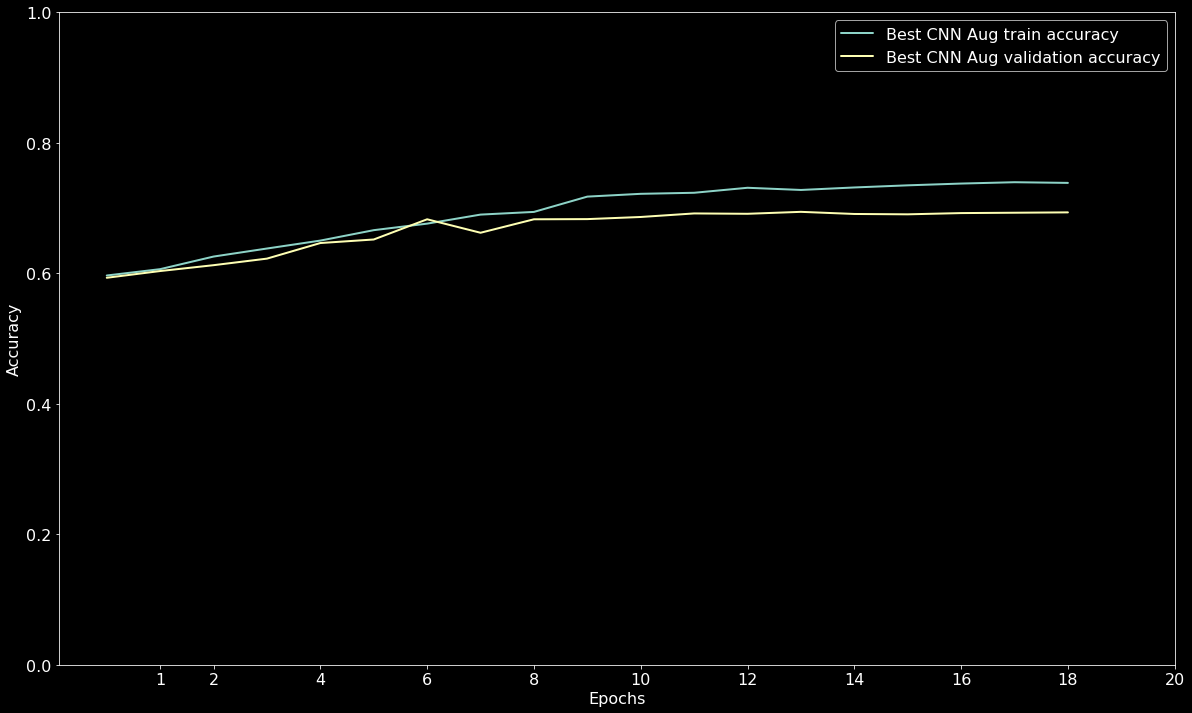

In [ ]:
print("Train Loss     : {0:.5f}".format(cnn_hs_aug.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(cnn_hs_aug.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(best_cnn_model_aug_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(cnn_hs_aug.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(cnn_hs_aug.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(best_cnn_model_aug_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'Best CNN Aug': cnn_hs_aug}, epochs=epochs, metric='loss')
plot_history(hs={'Best CNN Aug': cnn_hs_aug}, epochs=epochs, metric='accuracy')

For the CNN models, though they are poorer in performance we can see smooth lines both in loss and accuracy and train and test set. It also seems that the 20 epochs given were more than enough, since early stopping was activated on the 19th epoch

#### ResNet model

In [ ]:
# Evaluate on test data and show all the results.
best_resnet_model_eval = best_full_model_resnet.evaluate(test_data_gen, verbose=1)

100/100 [==============================] - 15s 145ms/step - loss: 0.7878 - accuracy: 0.7676


Train Loss     : 0.04415
Validation Loss: 0.65481
Test Loss      : 0.78783
---
Train Accuracy     : 0.98587
Validation Accuracy: 0.80848
Test Accuracy      : 0.76759



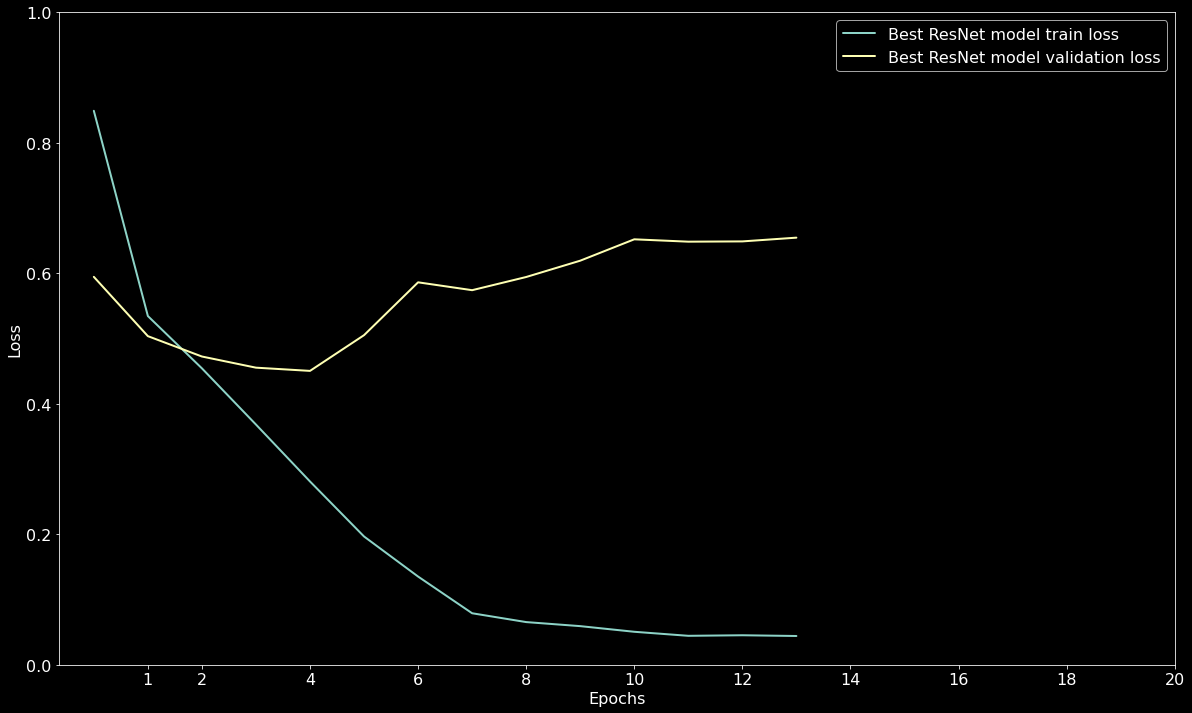

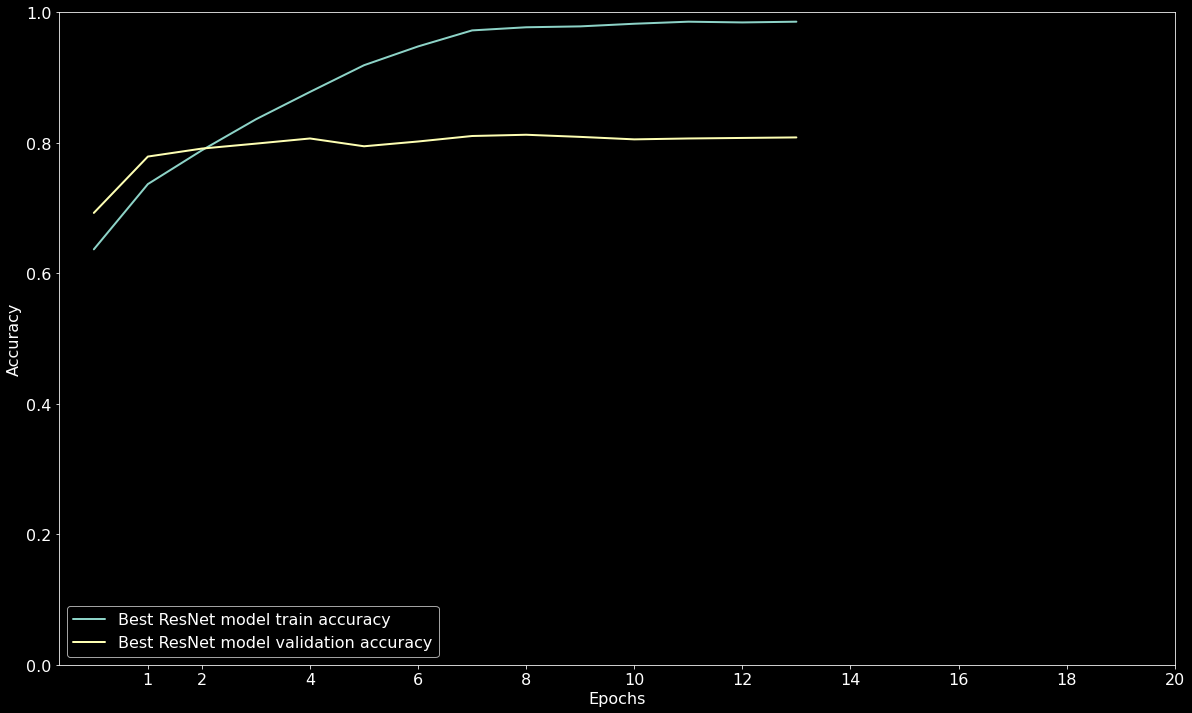

In [ ]:
print("Train Loss     : {0:.5f}".format(hs_best_full_model_resnet.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hs_best_full_model_resnet.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(best_resnet_model_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hs_best_full_model_resnet.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(hs_best_full_model_resnet.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(best_resnet_model_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'Best ResNet model': hs_best_full_model_resnet}, epochs=epochs, metric='loss')
plot_history(hs={'Best ResNet model': hs_best_full_model_resnet}, epochs=epochs, metric='accuracy')

In [ ]:
# Evaluate on test data and show all the results.
best_resnet_model_aug_eval = best_full_model_resnet_aug.evaluate(test_data_gen, verbose=1)

100/100 [==============================] - 15s 145ms/step - loss: 1.0401 - accuracy: 0.7785


Train Loss     : 0.03541
Validation Loss: 0.82272
Test Loss      : 1.04006
---
Train Accuracy     : 0.98829
Validation Accuracy: 0.80685
Test Accuracy      : 0.77854



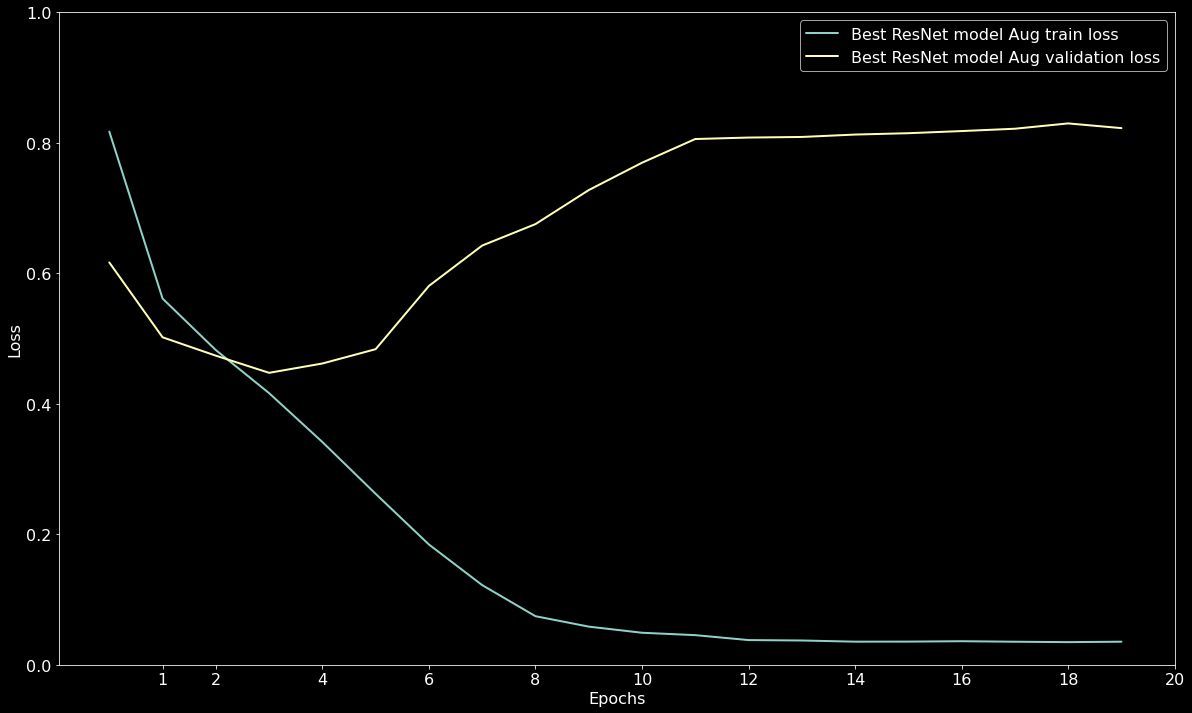

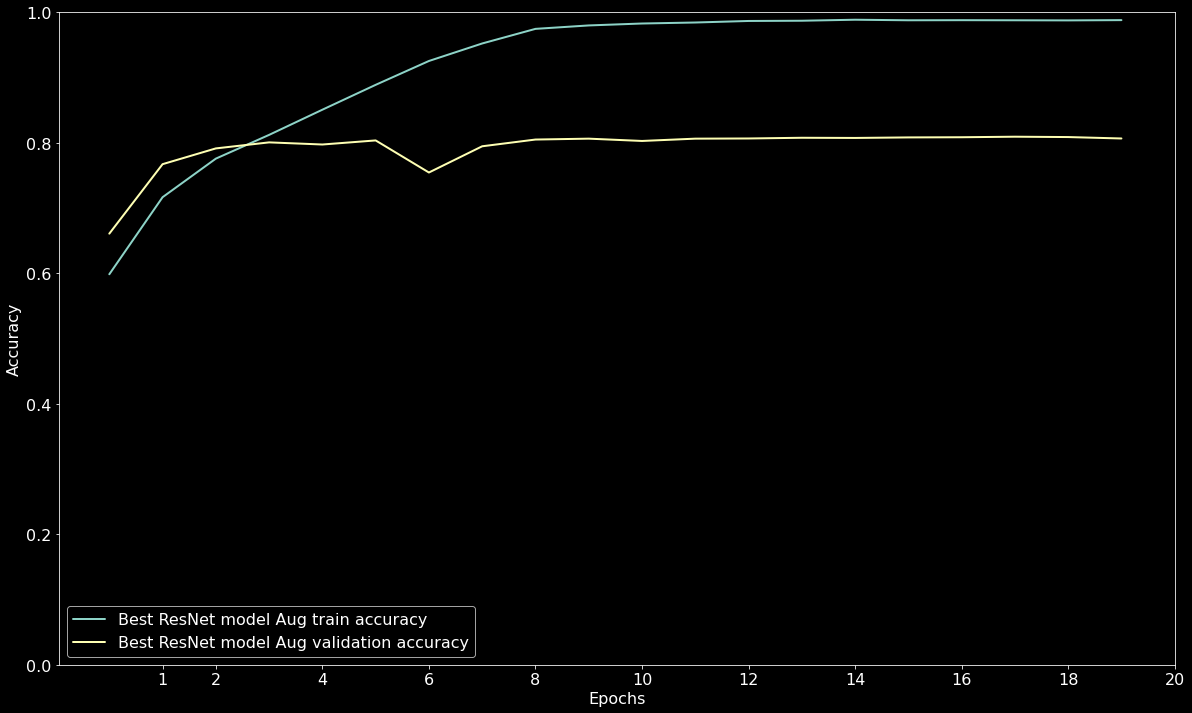

In [ ]:
print("Train Loss     : {0:.5f}".format(hs_best_full_model_resnet_aug.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hs_best_full_model_resnet_aug.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(best_resnet_model_aug_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hs_best_full_model_resnet_aug.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(hs_best_full_model_resnet_aug.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(best_resnet_model_aug_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'Best ResNet model Aug': hs_best_full_model_resnet_aug}, epochs=epochs, metric='loss')
plot_history(hs={'Best ResNet model Aug': hs_best_full_model_resnet_aug}, epochs=epochs, metric='accuracy')

For the ResNet model we can see that the Accuracy with the normal train dataset stabilizes earlier than the augmented train but also at a cost of overfitting on the train dataset

#### All models

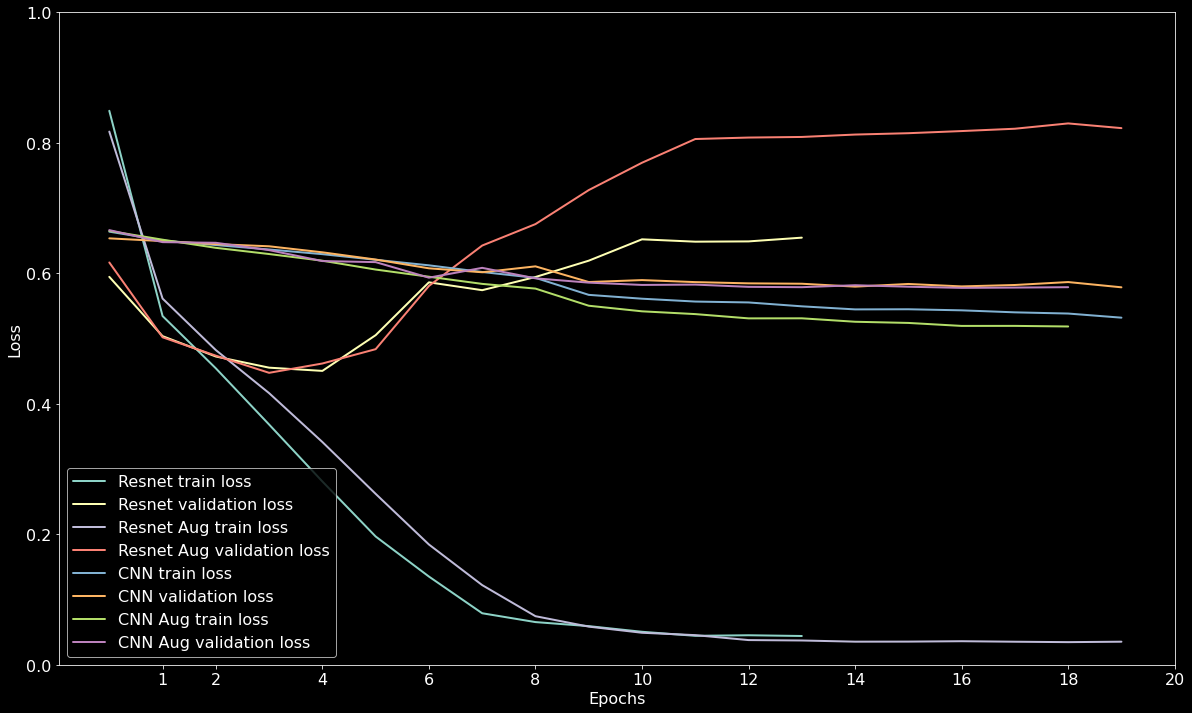

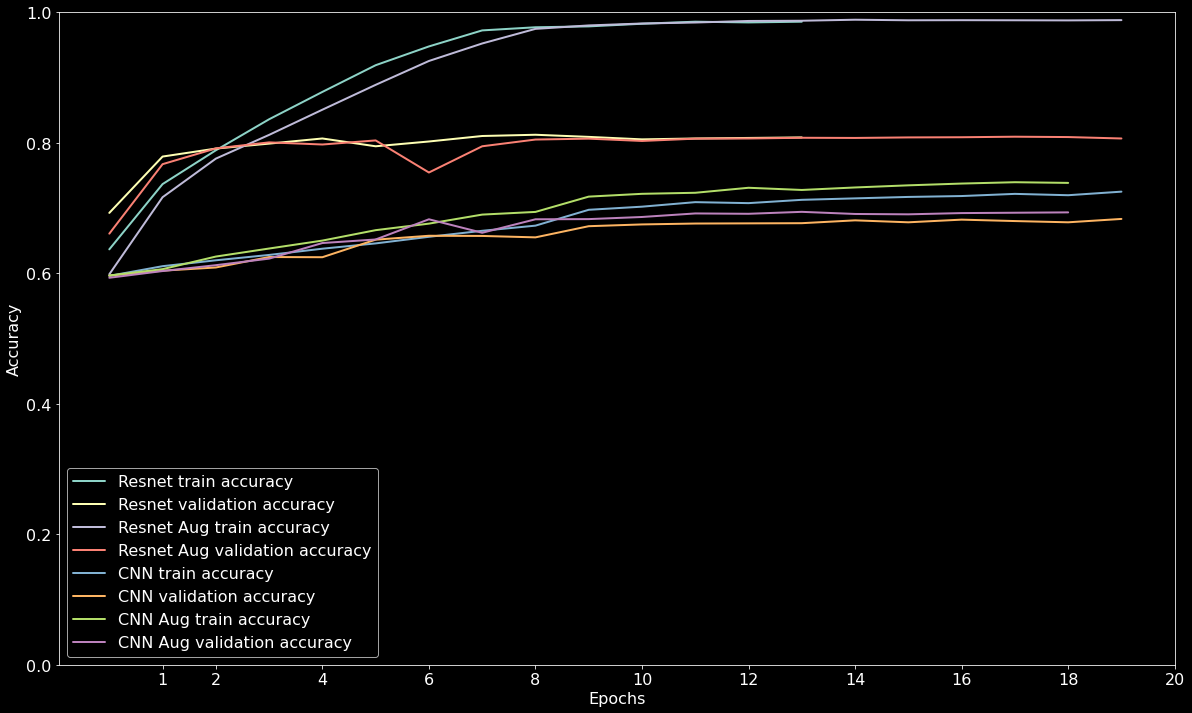

In [ ]:
# Plot train and validation error per epoch.
plot_history(
    hs={
        'Resnet': hs_best_full_model_resnet,
        'Resnet Aug': hs_best_full_model_resnet_aug,
        'CNN': cnn_hs,
        'CNN Aug': cnn_hs_aug
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'Resnet': hs_best_full_model_resnet,
        'Resnet Aug': hs_best_full_model_resnet_aug,
        'CNN': cnn_hs,
        'CNN Aug': cnn_hs_aug
    },
    epochs=epochs,
    metric='accuracy'
)

For the Resnet models we have an interesting case. Although the Loss and accuracy graphs clearly indicate that the model has overfitted in the train dataset, the predictions on the validation and test set seem to be more accurate than the CNN. Probably since, it was trained to track more general patterns, it was easier for it to memorize all the train data but still not taking predictions based only on the features of the train data alone.